<ipython-input-5-a201a6609e7a>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  births['day'].fillna(0, inplace=True)


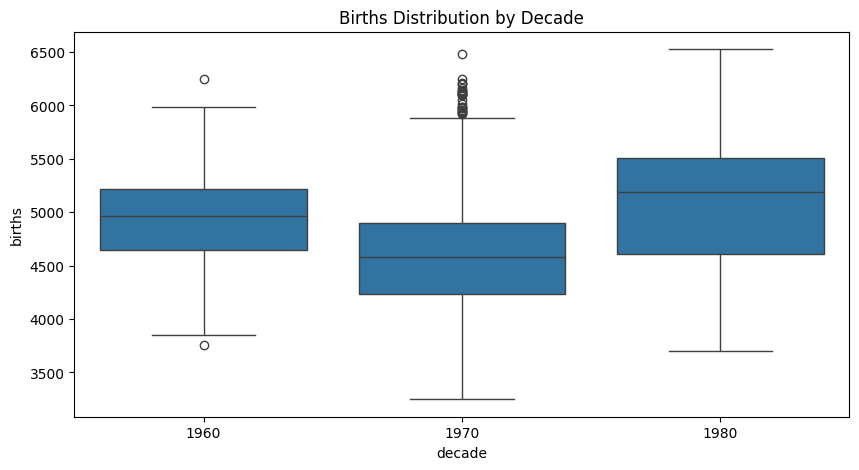

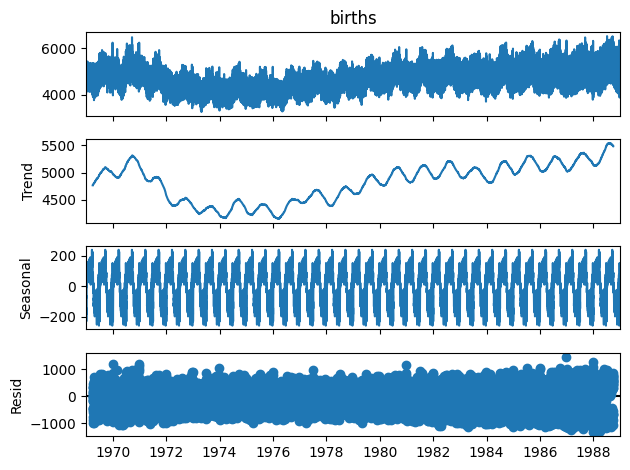

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

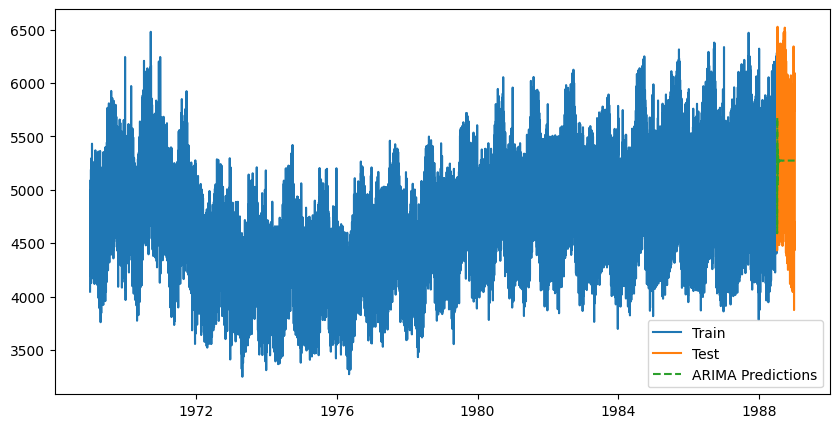

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8y5200t7/bktoe4jd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8y5200t7/0yot63lu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70374', 'data', 'file=/tmp/tmp8y5200t7/bktoe4jd.json', 'init=/tmp/tmp8y5200t7/0yot63lu.json', 'output', 'file=/tmp/tmp8y5200t7/prophet_modelcnacy2du/prophet_model-20250206122031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:20:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:20:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


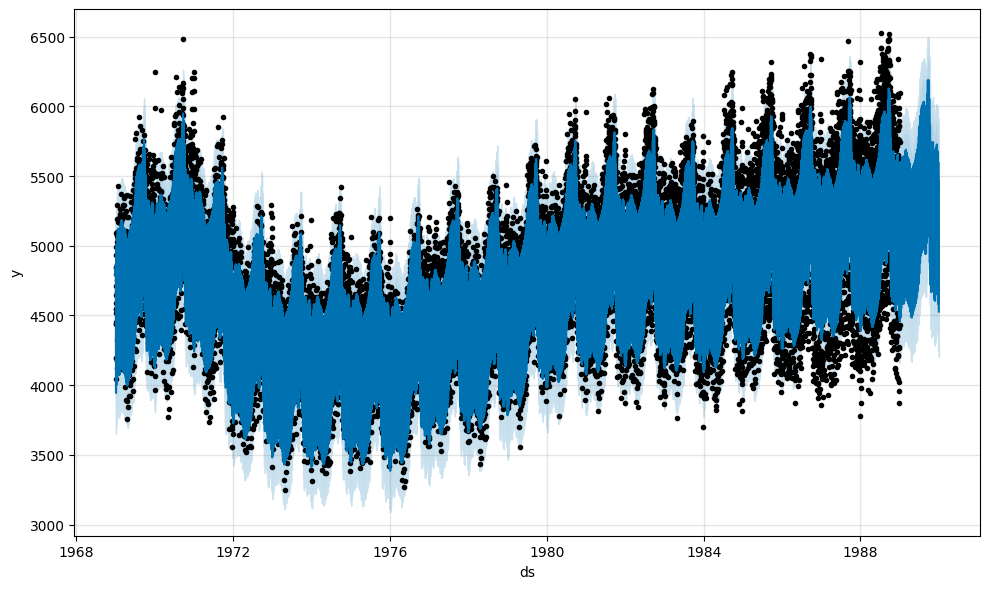

MAE: 193.44283700281392
RMSE: 222.8955718954967
T-test Statistic: -97.19714945381516, P-value: 0.0
There is a significant difference between weekend and weekday birth rates.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

!pip install prophet

births = pd.read_csv("births.csv")

births['day'].fillna(0, inplace=True)
births['day'] = births['day'].astype(int)
births['decade'] = 10 * (births['year'] // 10)

births['date'] = pd.to_datetime(births[['year', 'month', 'day']], errors='coerce')
births = births.dropna()
births.set_index('date', inplace=True)

q25, q75 = np.percentile(births['births'], [25, 75])
iqr = q75 - q25
threshold = 1.5 * iqr
lower, upper = q25 - threshold, q75 + threshold
births = births[(births['births'] > lower) & (births['births'] < upper)]

plt.figure(figsize=(10, 5))
sns.boxplot(data=births, x='decade', y='births')
plt.title('Births Distribution by Decade')
plt.show()

result = seasonal_decompose(births['births'], model='additive', period=365)
result.plot()
plt.show()

train, test = births['births'][:-365], births['births'][-365:]
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()
predictions = model_fit.forecast(len(test))

plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions, label='ARIMA Predictions', linestyle='dashed')
plt.legend()
plt.show()

prophet_df = births.reset_index()[['date', 'births']]
prophet_df.columns = ['ds', 'y']
model = Prophet()
model.fit(prophet_df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
model.plot(forecast)
plt.show()

births['day_of_week'] = births.index.dayofweek
X = births[['year', 'month', 'day', 'day_of_week']]
y = births['births']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')

weekend_births = births[births['day_of_week'].isin([5, 6])]['births']
weekday_births = births[~births['day_of_week'].isin([5, 6])]['births']
t_stat, p_value = stats.ttest_ind(weekend_births, weekday_births)
print(f'T-test Statistic: {t_stat}, P-value: {p_value}')

if p_value < 0.05:
    print("There is a significant difference between weekend and weekday birth rates.")
else:
    print("No significant difference in birth rates between weekends and weekdays.")
